# Laboratorio #4

**Esteban Zambrano - 22119**<br>
**Andrés Ortega - 22305**<br>
**Diego García - 22404**

In [ ]:
#!pip install openeo
#!pip install rasterio
#!pip install folium branca

In [93]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import openeo
import glob
import os
import re
import pandas as pd
import warnings
import seaborn as sns

from datetime import date
from pathlib import Path
from scipy.signal import find_peaks

In [8]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [2]:
#Areas de interes
lago_atitlan = {
    "west": -91.349,
    "east": -91.0702,
    "south": 14.5971,
    "north": 14.7648
}
lago_amatitlan = {
    "west": -90.66,
    "east": -90.58,
    "south": 14.43,
    "north": 14.51
}

bands_needed = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]

In [3]:
# Código de https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/#representative-images pasado a python

# Water body detection - credit Mohor Gartner
MNDWI_threshold = 0.42
NDWI_threshold = 0.4
filter_UABS = True
filter_SSI = False

def wbi(r, g, b, nir, swir1, swir2):
    # water surface
    ws = 0
    try:
        # Calc indices
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)

        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        wii = np.power(nir, 2) / r
        wri = (g + r) / (nir + swir1)
        puwi = 5.83 * g - 6.57 * r - 30.32 * nir + 2.25
        uwi = (g - 1.1 * r - 5.2 * nir + 0.4) / np.abs(g - 1.1 * r - 5.2 * nir)
        usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1

        if (mndwi > MNDWI_threshold or ndwi > NDWI_threshold or
            aweinsh > 0.1879 or aweish > 0.1112 or
            ndvi < -0.2 or ndwi_leaves > 1):
            ws = 1

        if filter_UABS and ws == 1:
            if (aweinsh <= -0.03) or (dbsi > 0):
                ws = 0

    except Exception:
        ws = 0
    return ws

# Floating vegetation
def FAI(a, b, c):
    return b - a - (c - a) * (783 - 665) / (865 - 665)

# Chlorophyll-a
def NDCI(a, b):
    return (b - a) / (b + a)

def classify_pixel(B02, B03, B04, B05, B07, B08, B8A, B11, B12):
    water = wbi(B04, B03, B02, B08, B11, B12)
    FAIv = FAI(B04, B07, B8A)
    NDCIv = NDCI(B04, B05)
    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071

    trueColor = [3 * B04, 3 * B03, 3 * B02]

    #  Render colour map
    if water == 0:
        return trueColor
    elif FAIv > 0.08:
        return [233/255, 72/255, 21/255]
    elif chl < 0.5:
        return [0, 0, 1.0]
    elif chl < 1:
        return [0, 0, 1.0]
    elif chl < 2.5:
        return [0, 59/255, 1]
    elif chl < 3.5:
        return [0, 98/255, 1]
    elif chl < 5:
        return [15/255, 113/255, 141/255]
    elif chl < 7:
        return [14/255, 141/255, 120/255]
    elif chl < 8:
        return [13/255, 141/255, 103/255]
    elif chl < 10:
        return [30/255, 226/255, 28/255]
    elif chl < 14:
        return [42/255, 226/255, 28/255]
    elif chl < 18:
        return [68/255, 226/255, 28/255]
    elif chl < 20:
        return [68/255, 226/255, 28/255]
    elif chl < 24:
        return [134/255, 247/255, 0]
    elif chl < 28:
        return [140/255, 247/255, 0]
    elif chl < 30:
        return [205/255, 237/255, 0]
    elif chl < 38:
        return [208/255, 240/255, 0]
    elif chl < 45:
        return [208/255, 240/255, 0]
    elif chl < 50:
        return [251/255, 210/255, 3/255]
    elif chl < 75:
        return [248/255, 207/255, 2/255]
    elif chl < 90:
        return [134/255, 247/255, 0]
    elif chl < 100:
        return [245/255, 164/255, 9/255]
    elif chl < 150:
        return [240/255, 159/255, 8/255]
    elif chl < 250:
        return [237/255, 157/255, 7/255]
    elif chl < 300:
        return [239/255, 118/255, 15/255]
    elif chl < 350:
        return [239/255, 101/255, 15/255]
    elif chl < 450:
        return [239/255, 100/255, 14/255]
    elif chl < 500:
        return [233/255, 72/255, 21/255]
    else:
        return [233/255, 72/255, 21/255]

In [4]:
def download_lake(spatial_extent, output_path):
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=spatial_extent,
        temporal_extent=["2025-02-01", "2025-07-31"],
        bands=bands_needed,
        max_cloud_cover=20
    )
    
    # Guardar resultado temporal en GeoTIFF
    temp_result = cube.save_result(format="GTIFF")
    job = connection.create_job(temp_result)
    job.start_and_wait()
    job.download_results(output_path)


def process_image(input_tif, output_tif):
    with rasterio.open(input_tif) as src:
        bands_data = src.read()
        transform = src.transform
        crs = src.crs
    
    # Extraer bandas por nombre
    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = bands_data
    
    # Salida con 3 canales RGB
    rgb = np.zeros((3, B02.shape[0], B02.shape[1]), dtype=np.float32)
    
    for i in range(B02.shape[0]):
        for j in range(B02.shape[1]):
            rgb_pixel = classify_pixel(
                B02[i, j], B03[i, j], B04[i, j], B05[i, j],
                B07[i, j], B08[i, j], B8A[i, j], B11[i, j], B12[i, j]
            )
            rgb[:, i, j] = rgb_pixel
    
    # Guardar resultado
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=rgb.shape[1],
        width=rgb.shape[2],
        count=3,
        dtype=rgb.dtype,
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(rgb[0], 1)
        dst.write(rgb[1], 2)
        dst.write(rgb[2], 3)

In [13]:
# Descargar imagenes de los lagos

# download_lake(lago_atitlan, "../data/imgsAti")
download_lake(lago_amatitlan, "../data/imgsAmati")

0:00:00 Job 'j-2508140616094aeab545825e9c041a06': send 'start'
0:00:13 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:18 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:25 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:33 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:43 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:00:55 Job 'j-2508140616094aeab545825e9c041a06': created (progress 0%)
0:01:11 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:01:30 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:01:55 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:02:26 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:03:03 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:03:50 Job 'j-2508140616094aeab545825e9c041a06': running (progress N/A)
0:04:48 Job 'j-2508140616094aeab545825e9c041a06': finished (progres

C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\4160958946.py:14: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(output_path)


In [16]:
# Procesar las imágenes descargadas según el script de sentinel-hub

file_ati = glob.glob(os.path.join("../data/imgsAti/", "openEO_*.tif"))[0]
file_amati = glob.glob(os.path.join("../data/imgsAmati/", "openEO_*.tif"))[0]

print("Archivo encontrado Ati:", file_ati)
print("Archivo encontrado Amati:", file_amati)

# Procesar usando tus funciones
for tif_file in glob.glob(os.path.join("../data/imgsAti/", "openEO_*.tif")):
    date = os.path.basename(tif_file).split("_")[1]  # Extrae "2025-03-07"
    output_name = f"../data/cyanobacAti/chl_Atitlan_{date}.tif"
    process_image(tif_file, output_name)

for tif_file in glob.glob(os.path.join("../data/imgsAmati/", "openEO_*.tif")):
    date = os.path.basename(tif_file).split("_")[1]  # Extrae "2025-03-07"
    output_name = f"../data/cyanobacAmati/chl_Amatitlan_{date}.tif"
    process_image(tif_file, output_name)

Archivo encontrado Ati: ../data/imgsAti\openEO_2025-02-07Z.tif
Archivo encontrado Amati: ../data/imgsAmati\openEO_2025-02-02Z.tif


C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:43: RuntimeWarning: overflow encountered in scalar multiply
  return b - a - (c - a) * (783 - 665) / (865 - 665)
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  wii = np.power(nir, 2) / r
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:26: RuntimeWarning: invalid value encountered in scalar subtract
  usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  return (b - a) / (b + a)
C:\Users\dgv31\AppData\Local\Temp\ipykernel_26224\1061942483.py:53: RuntimeWarning: invalid value encountered in scalar subtract

### Conviersión de arreglos a numpy 

In [24]:
# Extracción numérica (sin loops por píxel)

warnings.filterwarnings("ignore", category=RuntimeWarning)

def compute_indices_arrays(B02, B03, B04, B05, B07, B08, B8A, B11, B12,
                           mndwi_thr=0.42, ndwi_thr=0.40, filter_UABS=True):
    # Índices con divisiones seguras
    ndvi        = _safe_div(B08 - B04, B08 + B04)
    mndwi       = _safe_div(B03 - B11, B03 + B11)
    ndwi        = _safe_div(B03 - B08, B03 + B08)
    ndwi_leaves = _safe_div(B08 - B11, B08 + B11)

    aweish  = B02 + 2.5*B03 - 1.5*(B08 + B11) - 0.25*B12
    aweinsh = 4*(B03 - B11) - (0.25*B08 + 2.75*B11)
    dbsi    = _safe_div(B11 - B03, B11 + B03) - ndvi

    # Umbrales pensados para reflectancia 0–1
    ws = (
        (mndwi > mndwi_thr) |
        (ndwi >  ndwi_thr)  |
        (aweinsh > 0.1879)  |
        (aweish  > 0.1112)  |
        (ndvi <  -0.2)      |
        (ndwi_leaves > 1)
    )
    ws = np.where(np.isnan(ws), False, ws)

    if filter_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    # FAI, NDCI y clorofila
    FAI  = B8A - B04 - (B07 - B04) * (783 - 665) / (865 - 665 + 1e-6)
    NDCI = _safe_div(B05 - B04, B05 + B04)

    chl = 826.57*(NDCI**3) - 176.43*(NDCI**2) + 19*NDCI + 4.071

    chl = np.where(ws, chl, np.nan)
    chl = np.where(np.isfinite(chl), chl, np.nan)
    chl = np.where((chl < -5) | (chl > 300), np.nan, chl)

    return ws.astype(np.uint8), FAI, NDCI, chl

def read_s2_stack(path):
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        transform, crs = src.transform, src.crs
        nodata = src.nodata

    if nodata is not None:
        arr = np.where(arr == nodata, np.nan, arr)

    p99 = np.nanpercentile(arr, 99)
    if p99 > 1.5:   # heurística robusta
        arr = arr / 10000.0

    # Recortar valores por ruido
    arr = np.clip(arr, 0.0, 1.2)

    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = arr
    return (B02, B03, B04, B05, B07, B08, B8A, B11, B12), transform, crs

def _safe_div(num, den, eps=1e-6):
    den_ok = np.where(np.abs(den) > eps, den, np.nan)
    return num / den_ok

def write_singleband(path_out, array, transform, crs, dtype="float32", nodata_val=np.nan):
    profile = {
        "driver": "GTiff",
        "height": array.shape[0],
        "width":  array.shape[1],
        "count": 1,
        "dtype": dtype,
        "crs": crs,
        "transform": transform,
        "compress": "lzw"
    }
    with rasterio.open(path_out, "w", **profile) as dst:
        dst.write(array.astype(dtype), 1)

In [25]:
# Generación de rásters numéricos (clorofila-a) por lago

def extract_date_from_name(fname):
    # busca YYYY-MM-DD en el nombre
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(fname))
    return m.group(1) if m else "unknown"

def make_chla_rasters(img_dir, out_dir, lake_tag, overwrite=False):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    files = sorted(glob.glob(os.path.join(img_dir, "openEO_*.tif")))
    outputs = []
    for tif in files:
        date_tag = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(tif)).group(1)
        out_tif = os.path.join(out_dir, f"chla_{lake_tag}_{date_tag}.tif")
        if (not overwrite) and os.path.exists(out_tif):
            outputs.append(out_tif); print("Saltado:", os.path.basename(out_tif)); continue
        (B02,B03,B04,B05,B07,B08,B8A,B11,B12), transform, crs = read_s2_stack(tif)
        _, _, _, chl = compute_indices_arrays(B02,B03,B04,B05,B07,B08,B8A,B11,B12)
        with rasterio.open(
            out_tif, "w", driver="GTiff", height=chl.shape[0], width=chl.shape[1],
            count=1, dtype="float32", crs=crs, transform=transform, compress="lzw"
        ) as dst:
            dst.write(chl.astype("float32"), 1)
        outputs.append(out_tif)
        print("Guardado:", os.path.basename(out_tif))
    return outputs

outs_ati = make_chla_rasters("../data/imgsAti",   "../data/cyanobacAti_num",   "Atitlan",    overwrite=True)
outs_am  = make_chla_rasters("../data/imgsAmati", "../data/cyanobacAmati_num", "Amatitlan",  overwrite=True)


Guardado: chla_Atitlan_2025-02-07.tif
Guardado: chla_Atitlan_2025-02-25.tif
Guardado: chla_Atitlan_2025-02-27.tif
Guardado: chla_Atitlan_2025-03-02.tif
Guardado: chla_Atitlan_2025-03-04.tif
Guardado: chla_Atitlan_2025-03-07.tif
Guardado: chla_Atitlan_2025-03-09.tif
Guardado: chla_Atitlan_2025-03-12.tif
Guardado: chla_Atitlan_2025-03-14.tif
Guardado: chla_Atitlan_2025-03-22.tif
Guardado: chla_Atitlan_2025-03-24.tif
Guardado: chla_Atitlan_2025-04-03.tif
Guardado: chla_Atitlan_2025-04-11.tif
Guardado: chla_Atitlan_2025-04-13.tif
Guardado: chla_Atitlan_2025-04-15.tif
Guardado: chla_Atitlan_2025-04-16.tif
Guardado: chla_Atitlan_2025-04-18.tif
Guardado: chla_Atitlan_2025-04-28.tif
Guardado: chla_Atitlan_2025-05-03.tif
Guardado: chla_Atitlan_2025-05-13.tif
Guardado: chla_Atitlan_2025-07-10.tif
Guardado: chla_Atitlan_2025-07-17.tif
Guardado: chla_Atitlan_2025-07-20.tif
Guardado: chla_Amatitlan_2025-02-02.tif
Guardado: chla_Amatitlan_2025-02-07.tif
Guardado: chla_Amatitlan_2025-02-12.tif
Guarda

In [28]:
# Estadísticos por fecha

def summarize_chla(tif_list, lake):
    rows = []
    for tif in sorted(tif_list):
        date_tag = extract_date_from_name(tif)
        with rasterio.open(tif) as src:
            a = src.read(1).astype(np.float32)
        # Cobertura proporción de pixeles con dato
        finite = np.isfinite(a)
        coverage = finite.mean() if finite.size else 0.0
        if coverage == 0:
            mean = median = std = q10 = q50 = q90 = np.nan
            minv = maxv = np.nan
        else:
            vals = a[finite]
            mean   = float(np.nanmean(vals))
            median = float(np.nanmedian(vals))
            std    = float(np.nanstd(vals))
            q10, q50, q90 = [float(np.nanpercentile(vals, p)) for p in (10, 50, 90)]
            minv, maxv    = float(np.nanmin(vals)), float(np.nanmax(vals))
        rows.append({
            "lake": lake, "date": date_tag,
            "mean_chla": mean, "median": median, "std": std,
            "p10": q10, "p50": q50, "p90": q90,
            "min": minv, "max": maxv, "coverage": coverage
        })
    return pd.DataFrame(rows).sort_values(["date"])

df_ati = summarize_chla(outs_ati, "Atitlan")
df_am  = summarize_chla(outs_am,  "Amatitlan")

summary = pd.concat([df_ati, df_am], ignore_index=True)
summary.to_csv("../data/summary_point5.csv", index=False)
summary.head()


,lake,date,mean_chla,median,std,p10,p50,p90,min,max,coverage
0,Atitlan,2025-02-07,11.993536,4.813330,29.335297,0.407569,4.813330,21.414707,-4.996635,293.195007,0.101445
1,Atitlan,2025-02-25,3.722998,3.981339,2.054187,2.436786,3.981339,4.563935,-4.996631,244.598007,0.038985
2,Atitlan,2025-02-27,3.348401,3.621939,1.178722,2.045308,3.621939,4.398536,-4.999456,62.751328,0.227094
3,Atitlan,2025-03-02,4.640402,4.071000,11.578427,-1.089426,4.071000,6.239658,-4.990739,298.819946,0.017764
4,Atitlan,2025-03-04,3.186064,3.598156,1.450153,1.493005,3.598156,4.388079,-4.998645,70.529938,0.123400


In [29]:
def fill_missing_dates(df, start="2025-02-01", end="2025-07-31", method="mean"):
    # Crear rango de fechas completo
    idx = pd.date_range(start, end, freq="D")
    df = df.set_index(pd.to_datetime(df["date"]))
    df = df.reindex(idx)
    
    if method == "mean":
        mean_val = df["mean_chla"].mean(skipna=True)
        df["mean_chla"] = df["mean_chla"].fillna(mean_val)
    elif method == "interpolate":
        df["mean_chla"] = df["mean_chla"].interpolate(method="time")
    
    df["date"] = df.index.date
    return df.reset_index(drop=True)

df_ati_filled = fill_missing_dates(df_ati, method="mean")
df_am_filled  = fill_missing_dates(df_am,  method="mean")


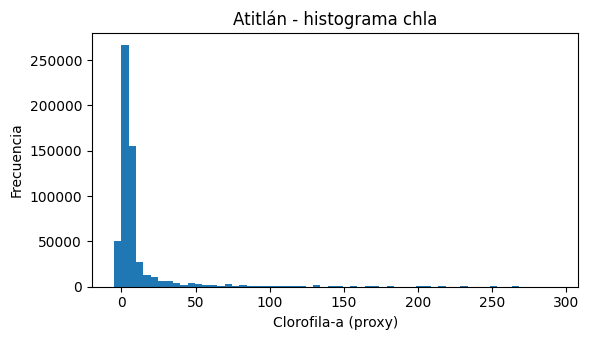

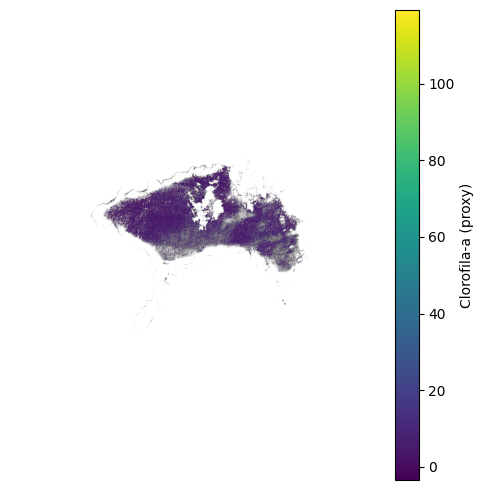

In [30]:
# QC visual (histograma y heatmap simple)

def quick_hist(tif_path, bins=60, title=None, png_out=None):
    with rasterio.open(tif_path) as src:
        a = src.read(1).astype(np.float32)
    vals = a[np.isfinite(a)]
    plt.figure(figsize=(6,3.5))
    plt.hist(vals, bins=bins)
    plt.title(title or os.path.basename(tif_path))
    plt.xlabel("Clorofila-a (proxy)"); plt.ylabel("Frecuencia")
    plt.tight_layout()
    if png_out:
        plt.savefig(png_out, dpi=140)
        plt.close()
    else:
        plt.show()

def quick_show(tif_path, png_out=None):
    with rasterio.open(tif_path) as src:
        a = src.read(1).astype(np.float32)
    vmin, vmax = np.nanpercentile(a, [2, 98])
    plt.figure(figsize=(5,5))
    plt.imshow(a, vmin=vmin, vmax=vmax)
    plt.colorbar(label="Clorofila-a (proxy)")
    plt.axis("off")
    plt.tight_layout()
    if png_out:
        plt.savefig(png_out, dpi=150)
        plt.close()
    else:
        plt.show()

if outs_ati:
    quick_hist(outs_ati[0], title="Atitlán - histograma chla")
    quick_show(outs_ati[0])


In [31]:
# Cargar el CSV recién generado
summary = pd.read_csv("../data/summary_point5.csv")

# Filtra por cobertura mínima del espejo de agua
summary = summary[summary["coverage"] >= 0.05].copy()

# Evita negativos residuales en los estadísticos agregados
summary["mean_chla"] = summary["mean_chla"].clip(lower=0)
summary["median"]    = summary["median"].clip(lower=0)
summary["p10"]       = summary["p10"].clip(lower=0)
summary["p50"]       = summary["p50"].clip(lower=0)
summary["p90"]       = summary["p90"].clip(lower=0)

summary.to_csv("../data/summary_point5_clean.csv", index=False)

### Análisis temporal 

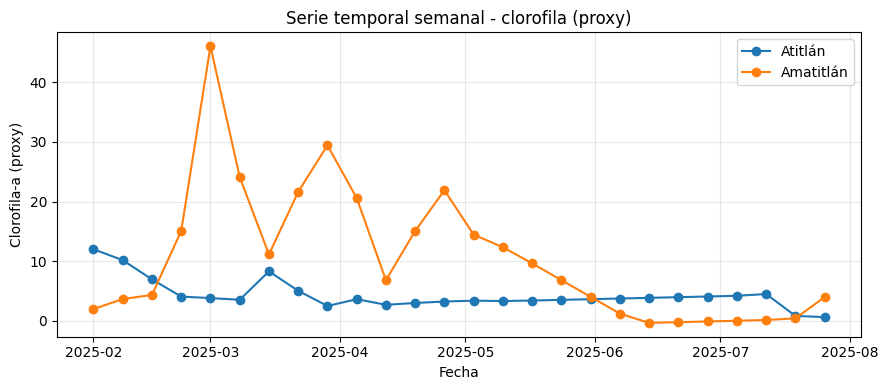

,lake,date,value,prominence
2,Amatitlan,2025-03-01,46.063412,44.104065
3,Amatitlan,2025-03-29,29.427913,18.307269
4,Amatitlan,2025-04-26,21.896625,15.091028
0,Atitlan,2025-03-15,8.272699,4.762964
1,Atitlan,2025-07-12,4.472270,2.006546


In [53]:
def build_ts(df_all, lake, start="2025-02-01", end="2025-07-31", freq="7D", fill="interpolate"):
    s = (df_all[df_all["lake"]==lake]
         .assign(date=pd.to_datetime(df_all["date"]))
         .set_index("date")["mean_chla"]
         .sort_index())

    # Rellena rango completo diario
    idx = pd.date_range(start, end, freq="D")
    s = s.reindex(idx)

    if fill == "mean":
        s = s.fillna(s.mean())
    else:
        s = s.interpolate("time")

    # Re-muestreo semanal
    s = s.resample(freq).mean()
    return s

summary_clean = pd.read_csv("../data/summary_point5.csv")

ts_ati = build_ts(summary_clean, "Atitlan", fill="interpolate")
ts_ama = build_ts(summary_clean, "Amatitlan", fill="interpolate")

# Graficar
plt.figure(figsize=(9,4))
plt.plot(ts_ati.index, ts_ati.values, marker="o", label="Atitlán")
plt.plot(ts_ama.index, ts_ama.values, marker="o", label="Amatitlán")
plt.title("Serie temporal semanal - clorofila (proxy)")
plt.xlabel("Fecha"); plt.ylabel("Clorofila-a (proxy)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

# Picos
def detect_peaks_adaptive(ts_values):
    # prominencia proporcional a la variabilidad de la serie
    prom = max(0.5, 0.6 * float(np.nanstd(ts_values)))
    peaks, props = find_peaks(ts_values, prominence=prom)
    return peaks, props, prom

peaks_ati, props_ati, prom_ati = detect_peaks_adaptive(ts_ati.values)
peaks_ama, props_ama, prom_ama = detect_peaks_adaptive(ts_ama.values)

peaks_df = pd.DataFrame({
    "lake": ["Atitlan"]*len(peaks_ati) + ["Amatitlan"]*len(peaks_ama),
    "date": list(ts_ati.index[peaks_ati]) + list(ts_ama.index[peaks_ama]),
    "value": list(ts_ati.values[peaks_ati]) + list(ts_ama.values[peaks_ama]),
    "prominence": list(props_ati["prominences"]) + list(props_ama["prominences"])
}).sort_values(["lake","date"])
peaks_df.to_csv("../data/series_temporales_picos.csv", index=False)
peaks_df.head()


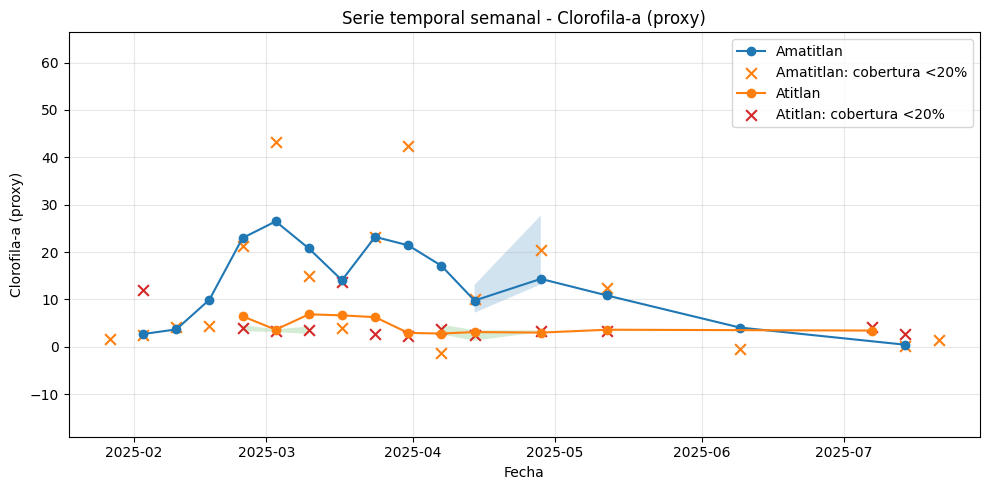

In [54]:
df = pd.read_csv("../data/summary_point5.csv", parse_dates=["date"])

# Ordenar y agrupar por semana
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly = df.groupby(['lake', 'week']).agg(
    mean_chla=('mean_chla', 'mean'),
    std_chla =('mean_chla',  'std'),
    coverage_min=('coverage','min'),
    coverage_mean=('coverage','mean')
).reset_index()

plt.figure(figsize=(10,5))
for lake in weekly['lake'].unique():
    sub = weekly[weekly['lake'] == lake].copy()
    sub['smooth'] = sub['mean_chla'].rolling(3, center=True).mean()
    # Línea principal
    plt.plot(sub['week'], sub['smooth'], marker='o', label=lake)
    plt.fill_between(sub['week'],
                     sub['mean_chla'] - sub['std_chla'],
                     sub['mean_chla'] + sub['std_chla'],
                     alpha=0.2)
    
    low = sub[sub['coverage_min'] < 0.2]
    if not low.empty:
        plt.scatter(low['week'], low['mean_chla'], marker='x', s=60,
                    label=f'{lake}: cobertura <20%')

plt.title("Serie temporal semanal - Clorofila-a (proxy)")
plt.xlabel("Fecha")
plt.ylabel("Clorofila-a (proxy)")
plt.grid(alpha=0.3)
plt.legend(); 
plt.tight_layout()
plt.show()


En este análisis, trabajamos con imágenes satelitales Sentinel-2 filtradas previamente para asegurar que la cobertura de nubes en la imagen completa sea menor al 20%.

Sin embargo, al procesar las imágenes, calculamos un indicador adicional llamado coverage, que representa el porcentaje de píxeles del lago visibles (es decir, sin nubes ni áreas inválidas) dentro del área de interés.
Este porcentaje no es la nubosidad de la escena completa, sino una métrica específica del lago.

Por lo tanto:

Un valor de coverage < 20% significa que, aunque la imagen completa tenga poca nubosidad (según Sentinel), la parte correspondiente al lago tiene menos del 20% de píxeles útiles.

Esto puede deberse a que las nubes se concentran justo sobre el lago, o a sombras y artefactos que afectan la delimitación del cuerpo de agua.

En la segunda gráfica de series temporales, estos días con coverage < 20% en el lago se marcaron con una "X" para facilitar su identificación visual.

### Análisis espacial

In [171]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.crs import CRS
from rasterio.transform import array_bounds
from IPython.display import display
from datetime import datetime, timedelta
from PIL import Image
import folium, branca.colormap as bcm
import base64

In [162]:
def agregar_poligono_lago(mapa, bounds, color_hex="#1f78b4", fill_opacity=0.4):
    """
    Dibuja un polígono rectangular sobre el lago usando los bounds del raster.
    Args:
        mapa: objeto folium.Map
        bounds: objeto BoundingBox o lista [[S, W], [N, E]]
        color_hex: color del borde y relleno
        fill_opacity: opacidad del relleno
    """
    if hasattr(bounds, "bottom"):
        south, west, north, east = bounds.bottom, bounds.left, bounds.top, bounds.right
    else:
        (south, west), (north, east) = bounds
    folium.Rectangle(
        bounds=[[south, west], [north, east]],
        color=color_hex,
        weight=2,
        fill=True,
        fill_color=color_hex,
        fill_opacity=fill_opacity
    ).add_to(mapa)

In [163]:
def list_rasters(lake_tag, base="../data"):
    folder = os.path.join(base, f"cyanobac{'Amati' if lake_tag=='Amatitlan' else 'Ati'}_num")
    pats = [f"chla_{lake_tag}_*.tif", f"chl_{lake_tag}_*.tif",
            f"chla_{lake_tag}_*.tif.tif", f"chl_{lake_tag}_*.tif.tif"]
    files = []
    for p in pats:
        files.extend(glob.glob(os.path.join(folder, p)))
    return sorted(set(files))

def extract_date(path):
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", os.path.basename(path))
    return m.group(1) if m else "unknown"

def quick_inventory():
    for lake in ["Amatitlan","Atitlan"]:
        files = list_rasters(lake)
        print(f"[{lake}] encontrados: {len(files)}")
        for f in files[:3]:
            print("   ", os.path.basename(f))
    print("— fin inventario —")

quick_inventory()


[Amatitlan] encontrados: 23
    chla_Amatitlan_2025-02-02.tif
    chla_Amatitlan_2025-02-07.tif
    chla_Amatitlan_2025-02-12.tif
[Atitlan] encontrados: 23
    chla_Atitlan_2025-02-07.tif
    chla_Atitlan_2025-02-25.tif
    chla_Atitlan_2025-02-27.tif
— fin inventario —


In [164]:
def read_array_and_meta(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)
        return arr, src.transform, src.crs, src.width, src.height, src.bounds

def to_wgs84(path):
    arr, src_transform, src_crs, width, height, src_bounds = read_array_and_meta(path)
    if src_crs is None:
        raise ValueError("El GeoTIFF no declara CRS.")
    src_crs = CRS.from_user_input(src_crs)
    if src_crs.to_epsg() == 4326:
        return arr, src_bounds
    dst_crs = CRS.from_epsg(4326)
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, *src_bounds
    )
    dst = np.full((dst_height, dst_width), np.nan, dtype=np.float32)
    reproject(
        source=arr, destination=dst,
        src_transform=src_transform, src_crs=src_crs,
        dst_transform=dst_transform, dst_crs=dst_crs,
        resampling=Resampling.nearest, dst_nodata=np.nan
    )
    south, west, north, east = array_bounds(dst_height, dst_width, dst_transform)
    from rasterio.coords import BoundingBox
    bounds = BoundingBox(left=west, bottom=south, right=east, top=north)
    return dst, bounds

In [165]:
def plot_static_minimal(tif_path, title=None, out_png=None):
    arr, *_ = read_array_and_meta(tif_path)
    finite = np.isfinite(arr)
    if not np.any(finite):
        print(f"[WARN] Sin datos válidos: {os.path.basename(tif_path)}")
        return
    vmin, vmax = np.nanpercentile(arr[finite], [2,98])
    plt.figure(figsize=(5.2,5))
    im = plt.imshow(arr, vmin=vmin, vmax=vmax, cmap="viridis")
    plt.colorbar(im, label="Clorofila-a (proxy)")
    plt.title(title or os.path.basename(tif_path))
    plt.axis("off"); plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160); plt.close()
    else:
        plt.show()

for lake in ["Amatitlan","Atitlan"]:
    files = list_rasters(lake)
    if files:
        out = f"../data/mapas/quick_{lake}.png"
        plot_static_minimal(files[0], title=f"{lake} {extract_date(files[0])}", out_png=out)
        print(f"[OK] Guardado {out}")
    else:
        print(f"[ERROR] No hay .tif para {lake}")


[OK] Guardado ../data/mapas/quick_Amatitlan.png
[OK] Guardado ../data/mapas/quick_Atitlan.png


In [166]:
cov = pd.read_csv("../data/summary_point5.csv")
cov["date"] = pd.to_datetime(cov["date"]).dt.strftime("%Y-%m-%d")

def find_file_for_date(lake_tag, date_str):
    for f in list_rasters(lake_tag):
        if date_str in f:
            return f
    return None

def title_with_cov(lake, d):
    row = cov[(cov.lake==lake) & (cov.date==d)]
    if len(row):
        return f"{lake} - {d}  (cov: {row.coverage.values[0]*100:.1f}%)"
    return f"{lake} - {d}"

def compare_dates_grid(lake_tag, dates, out_png=None):
    valid_items, finite_vals = [], []
    for d in dates:
        f = find_file_for_date(lake_tag, d)
        if f is None:
            valid_items.append((d, None, None)); continue
        try:
            arr, _ = to_wgs84(f)
        except Exception as e:
            print(f"[{lake_tag}] reproyección falló en {os.path.basename(f)}: {e}")
            valid_items.append((d, None, f)); continue
        finite = np.isfinite(arr)
        if np.any(finite):
            valid_items.append((d, arr, f))
            finite_vals.append(arr[finite])
        else:
            valid_items.append((d, None, f))

    if len(finite_vals) == 0:
        print(f"[{lake_tag}] Ninguna fecha con datos válidos:", dates)
        return

    finite_concat = np.concatenate([v.ravel() for v in finite_vals])
    vmin, vmax = np.nanpercentile(finite_concat, [2, 98])

    n = len(dates)
    cols = min(n, 3)
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5.2 * cols, 5 * rows), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    im = None
    for ax, (d, arr, f) in zip(axes, valid_items):
        if arr is None:
            ax.set_title(f"{lake_tag} - {d} (sin datos)")
            ax.axis("off")
            continue
        im = ax.imshow(arr, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.set_title(title_with_cov(lake_tag, d))
        ax.axis("off")

    for ax in axes[len(valid_items):]:
        ax.axis("off")

    if im is not None:
        fig.colorbar(im, ax=axes[:len(valid_items)], label="Clorofila-a (proxy)")

    if out_png:
        plt.savefig(out_png, dpi=170, bbox_inches="tight")
        plt.close()
        print(f"[OK] Guardado {out_png}")
    else:
        plt.show()

def available_dates(lake_tag):
    files = list_rasters(lake_tag)
    dates = []
    for f in files:
        d = extract_date(f)
        if d != "unknown":
            dates.append(d)
    return sorted(set(dates))

def nearest_available_dates(lake_tag, target_dates, max_delta_days=6):
    """
    Para cada fecha objetivo (picos semanales), busca la fecha de .tif
    más cercana dentro de ±max_delta_days. Devuelve lista de YYYY-MM-DD.
    """
    avail = [datetime.strptime(d, "%Y-%m-%d") for d in available_dates(lake_tag)]
    chosen = []
    for td in target_dates:
        if isinstance(td, str):
            dt = datetime.strptime(td[:10], "%Y-%m-%d")
        else:
            dt = pd.to_datetime(td).to_pydatetime()
        if not avail:
            break
        best = min(avail, key=lambda a: abs(a - dt))
        if abs(best - dt) <= timedelta(days=max_delta_days):
            chosen.append(best.strftime("%Y-%m-%d"))
    return sorted(set(chosen))

def pick_dates_for_lake(lake_tag, n=3):
    csv_p = "../data/series_temporales_picos.csv"
    if os.path.exists(csv_p):
        peaks = pd.read_csv(csv_p, parse_dates=["date"])
        sub = peaks[peaks["lake"]==lake_tag].sort_values("value", ascending=False)
        target = list(sub["date"])[:n*2]
        mapped = nearest_available_dates(lake_tag, target, max_delta_days=6)
        if mapped:
            return mapped[:n]
    return available_dates(lake_tag)[:n]

dates_am = pick_dates_for_lake("Amatitlan", 3)
dates_ati = pick_dates_for_lake("Atitlan", 3)
print("Fechas AM:", dates_am)
print("Fechas ATI:", dates_ati)

compare_dates_grid("Amatitlan", dates_am, out_png="../data/mapas/mapas_am_comparacion.png")
compare_dates_grid("Atitlan",   dates_ati, out_png="../data/mapas/mapas_ati_comparacion.png")

Fechas AM: ['2025-02-27', '2025-03-26', '2025-04-28']
Fechas ATI: ['2025-03-14', '2025-07-10']
[OK] Guardado ../data/mapas/mapas_am_comparacion.png
[OK] Guardado ../data/mapas/mapas_ati_comparacion.png


In [180]:
def rgba_from_array(arr, cmap="viridis", vmin=None, vmax=None, max_px=1400):
    finite = np.isfinite(arr)
    if not np.any(finite):
        raise ValueError("Raster sin datos válidos.")
    if vmin is None or vmax is None:
        vmin, vmax = np.nanpercentile(arr[finite], [2, 98])
    norm = np.clip((arr - vmin) / (vmax - vmin + 1e-9), 0, 1)
    rgba = plt.get_cmap(cmap)(norm, bytes=True)
    rgba[~finite] = [0,0,0,0]

    H, W = rgba.shape[:2]
    scale = max(H, W) / float(max_px)
    if scale > 1.0:
        newW, newH = int(W/scale), int(H/scale)
        rgba = np.array(Image.fromarray(rgba, mode="RGBA")
                        .resize((newW, newH), Image.BILINEAR))
    return rgba, float(vmin), float(vmax)

def save_overlay_png(rgba, out_png):
    out_png = Path(out_png)
    out_png.parent.mkdir(parents=True, exist_ok=True)
    Image.fromarray(rgba, mode="RGBA").save(out_png)
    return str(out_png)

def folium_overlay_from_tif(tif_path, html_out, name=None, opacity=1.0,
                            cmap="viridis", max_px=1400):
    arr, bounds = to_wgs84(tif_path)

    rgba, vmin, vmax = rgba_from_array(arr, cmap=cmap, max_px=max_px)
    png_path = Path(html_out).with_suffix(".png")
    save_overlay_png(rgba, png_path)

    with open(png_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    data_uri = f"data:image/png;base64,{b64}"

    west, south, east, north = bounds.bottom, bounds.left, bounds.top, bounds.right
    m = folium.Map(tiles="CartoDB positron")
    m.fit_bounds([[south, west], [north, east]])

    folium.raster_layers.ImageOverlay(
        image=data_uri,
        bounds=[[south, west], [north, east]],
        opacity=opacity,
        name=name or Path(tif_path).name,
        cross_origin=False,
        zindex=1000
    ).add_to(m)

    cm = bcm.linear.viridis.scale(vmin, vmax)
    cm.caption = "Clorofila-a (proxy)"
    cm.add_to(m)
    folium.LayerControl().add_to(m)

    html_out = Path(html_out)
    html_out.parent.mkdir(parents=True, exist_ok=True)
    m.save(str(html_out))
    print(f"[OK] HTML: {html_out.name}  PNG: {png_path.name}  (dir: {html_out.parent})")
    return str(html_out)


In [181]:
# Un ejemplo (Atitlán 2025-02-07)
tif_demo = find_file_for_date("Atitlan", "2025-02-07")
html_file = "../data/mapas/mapa_atitlan_2025-02-07.html"
folium_overlay_from_tif(tif_demo, html_file, name="Atitlán 2025-02-07", max_px=1400)
print("Mapa guardado como mapa_amatitlan.html. Ábrelo en tu navegador.")


[OK] HTML: mapa_atitlan_2025-02-07.html  PNG: mapa_atitlan_2025-02-07.png  (dir: ..\data\mapas)
Mapa guardado como mapa_amatitlan.html. Ábrelo en tu navegador.
